In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PINGU.importer import *
from PINGU.processer import *
from PINGU.main import get_all_events,get_events
from functions import perform_chisq
from DC.event_processing import list_of_params_nsi,get_param_list, get_best_fit, nufit_params_nsi_IO
from PINGU.event_processing import return_precomputed_nsi, get_deltachi, to_hist,get_marginalized_array
from scipy.stats import chi2
from plotter import save, savethesis
import pickle
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
Ebins_2018_midpoints = Ebins_2018[0:-1] +np.diff(Ebins_2018)/2

In [2]:
ndim = 3
livetime = 3*365*24*3600 #Effective livetime table1 DC2019 2.45
precomputed_events = True
IO=False
ordering = 'IO' if IO else 'NO'
dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=5, 
                                                                                   th23N=5, 
                                                                          ett=5e-2, ettN=1, 
                                                                          emt=2e-2, emtN=10, 
                                                                          eem=2e-1, eemN=1, 
                                                                          eet=2e-1, eetN=1, 
                                                                          IO=IO)

print('dm:', dm31_range)
print('th:', th23_range)
print('ett:', ett_range)
print('emt:', emt_range)
print('eem:', eem_range)
print('eet:', eet_range)
param_dict = nufit_params_nsi_IO if IO else nufit_params_nsi

param_list = list_of_params_nsi(param_dict, dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range)

dm: [0.002 0.002 0.003 0.003 0.003]
th: [0.7   0.767 0.835 0.859 0.902]
ett: [0.]
emt: [-0.02  -0.015 -0.01  -0.005  0.     0.005  0.01   0.015  0.02 ]
eem: [0.]
eet: [0.]


In [10]:
H1 = pickle.load(open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime
H0 = pickle.load(open(f'./pre_computed/H0_{ordering}_PINGU.p','rb'))*livetime

In [63]:
# track = pickle.load(open(f'./pre_computed/H1_NO_PINGU_1_5x5x9x1x1x1.p','rb'))
# cascade = pickle.load(open(f'./pre_computed/H1_NO_PINGU_0_5x5x9x1x1x1.p','rb'))
# new = np.concatenate((cascade,track), axis=1)
# new_name = 'H1_NO_PINGU_1_5x5x9x1x1x1.p'.replace('_1_','_')
# #new = np.swapaxes(new,2,3)
# pickle.dump(new,open(f'./pre_computed/{new_name}','wb'))


In [17]:
#H1 = new*livetime
#H1 = np.swapaxes(H1,2,3)
#pickle.dump(H1,open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','wb'))

In [11]:
sigma_a = 0.25
sigma_b = 0.04
f = 0#.05
chisq,  best_fit_index = get_deltachi([H for H in H1],H0,0,[sigma_a,sigma_b],f,x0=[1,0])

reshaped_chisq = chisq.reshape(len(eet_range),
                               len(eem_range),
                               len(emt_range), 
                               len(ett_range), 
                               len(th23_range), 
                               len(dm31_range)) #reshaped_chisq[eet,eem,emt,emm,th23,dm31]
minimum_oscillation = np.min(reshaped_chisq,axis=(0,1,2,3)).reshape(1,1,1,1,len(th23_range),len(dm31_range)) #Marginalize osc params
deltachi = reshaped_chisq - minimum_oscillation


best_eet_index,best_eem_index,best_emt_index,best_ett_index,best_th23_index, best_dm31_index = np.unravel_index(best_fit_index,deltachi.shape)
best_dm31, best_th23, best_ett, best_emt, best_eem, best_eet = (dm31_range[best_dm31_index], 
                                                                th23_range[best_th23_index],
                                                                ett_range[best_ett_index],
                                                                emt_range[best_emt_index],
                                                                eem_range[best_eem_index],
                                                                eet_range[best_eet_index])
best_fit_params = param_list[best_fit_index]

assert best_fit_params['dm_31'] == best_dm31 
assert best_fit_params['theta_23'] == best_th23
assert best_fit_params['e_tt'] == best_ett
assert best_fit_params['e_mt'] == best_emt
assert best_fit_params['e_em'] == best_eem
assert best_fit_params['e_et'] == best_eet

marginalized_deltachi = deltachi[:,:,:,:,best_th23_index,best_dm31_index].T
deltachi_ett = marginalized_deltachi[:,best_emt_index, best_eem_index, best_eet_index]
deltachi_emt = marginalized_deltachi[best_ett_index,:, best_eem_index, best_eet_index]
deltachi_eem = marginalized_deltachi[best_ett_index,best_emt_index, :, best_eet_index]
deltachi_eet = marginalized_deltachi[best_ett_index,best_emt_index, best_eem_index, :]

In [3]:
marginalized_arrays_NO=[]
marginalized_arrays_IO=[]
nsi_param_range=[]
N = 10 - 2
sigma_a = 0.25
sigma_b = 0.04
f = 0#.05
for ordering in ['NO','IO']:
    for i,nsi_param in enumerate(['ett','emt','eem','eet']):
        ettN,emtN,eemN,eetN = 0,0,0,0
        if nsi_param == 'ett':
            ettN = 1
        elif nsi_param == 'emt':
            emtN = 1
        elif nsi_param == 'eem':
            eemN = 1
        elif nsi_param == 'eet':
            eetN = 1
        dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N= 5, th23N = 5, 
                                                                                        ett = 5e-2, ettN = N*(ettN)+1,
                                                                                        emt = 2e-2, emtN = N*(emtN)+1,
                                                                                        eem = 2e-1, eemN = N*(eemN)+1,
                                                                                        eet = 2e-1 , eetN = N*(eetN)+1,
                                                                                        IO = True if ordering == 'IO' else False)
        param_dict = nufit_params_nsi_IO if ordering == 'IO' else nufit_params_nsi     
        param_list = list_of_params_nsi(param_dict, dm31_range, th23_range,ett_range, emt_range, eem_range,eet_range) 
        try:
            H1 = pickle.load(open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime
            H0 = pickle.load(open(f'./pre_computed/H0_{ordering}_PINGU.p','rb'))*livetime

            marg_array = get_marginalized_array(H1,H0,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, nsi_param, sigma_a,sigma_b, f)
            if ordering == 'NO':
                marginalized_arrays_NO.append(marg_array)
            elif ordering == 'IO':
                marginalized_arrays_IO.append(marg_array)
            param_range = ettN*ett_range + emtN*emt_range + eemN*eem_range + eetN*eet_range #Assumes 3d plot
            nsi_param_range.append(param_range)
        except FileNotFoundError:
            pass #No IO found

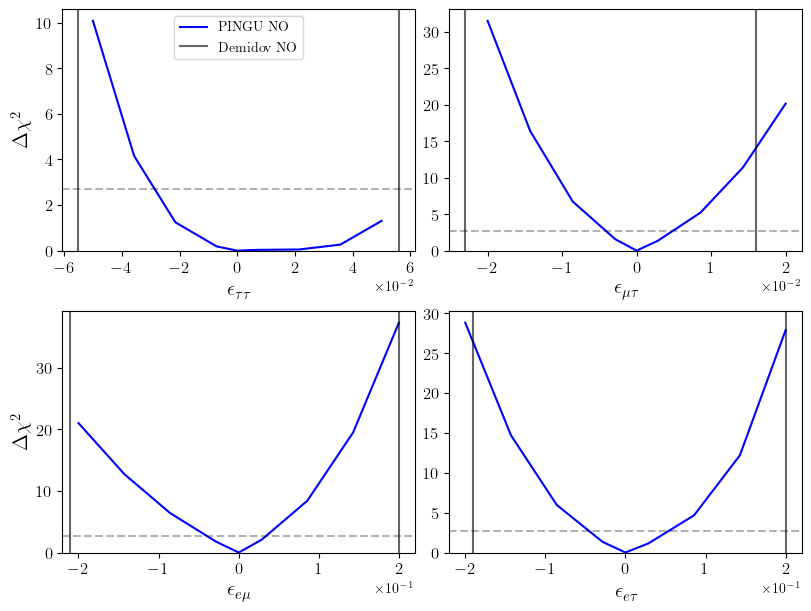

In [5]:
fig, ax = plt.subplots(2,2,figsize=(8,6), constrained_layout=True)
ax = ax.flatten()
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
xlabels = [r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$', r'$\epsilon_{e\tau}$']
demidovs =[demidov_ett, demidov_emt, demidov_eem, demidov_eet]
for i in range(4):
    ax[i].plot(nsi_param_range[i], marginalized_arrays_NO[i], label='PINGU NO', color='blue')
    #ax[i].plot(nsi_param_range[i], marginalized_arrays_IO[i], label='IO', color='green')
    ax[i].axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

    ax[i].axvline(demidovs[i][0], alpha=0.6,c='black', label=r'Demidov NO')
    ax[i].axvline(demidovs[i][1], alpha=0.6,c='black')
    ax[i].set_ylim(bottom=0)
    #ax[i].set_xlim((nsi_param_range[i].min(), nsi_param_range[i].max()))
    ax[i].set_xlabel(xlabels[i], fontsize=15)
    ax[i].tick_params(labelsize=12)
    ax[i].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax[0].set_ylabel(r'$\Delta \chi^2$', fontsize=15)
ax[2].set_ylabel(r'$\Delta \chi^2$', fontsize=15)
ax[0].legend()
save(fig, 'PINGU_3D_NO')
savethesis(fig, 'PINGU_3D_NO')

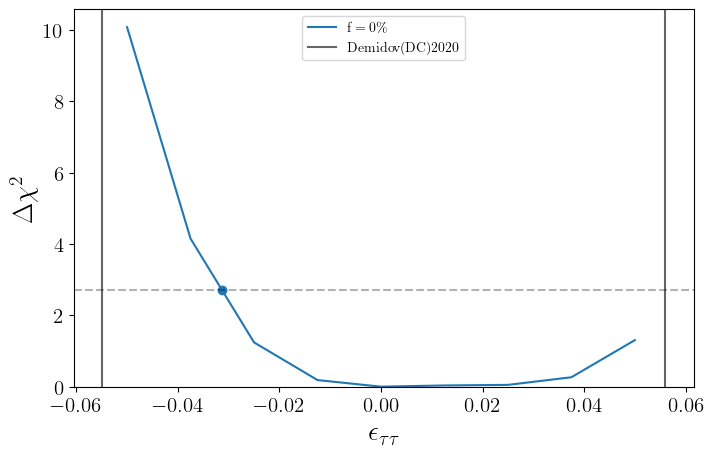

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
demidov_ett = (-0.055, 0.056)
plt.plot(ett_range, deltachi_ett,label=r'$\mathrm{f = 0\%}$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')


plt.axvline(demidov_ett[0], alpha=0.6,c='black', label=r'$\mathrm{Demidov (DC) 2020}$')
plt.axvline(demidov_ett[1], alpha=0.6,c='black')

plt.ylim(bottom=0)
plt.xlabel(r'$\epsilon_{\tau\tau}$', fontsize=20)
plt.ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend()
#save(fig, 'PINGU_3D_ett')

In [7]:
print(deltachi_ett)
print(ett_range)
x1 = deltachi_ett[1]
x2 = deltachi_ett[2]
y2 = ett_range[2]
y1 = ett_range[1]

print((y2-y1)/(x2+x1) * chi2.ppf(0.9,1) + y1)
print(dm31_range[best_dm31_index],th23_range[best_th23_index]*180/np.pi)

[10.074  4.149  1.241  0.185  0.     0.034  0.05   0.264  1.304]
[-0.05  -0.038 -0.025 -0.012  0.     0.012  0.025  0.038  0.05 ]
-0.03122504271720813
0.002517 49.20000000000001


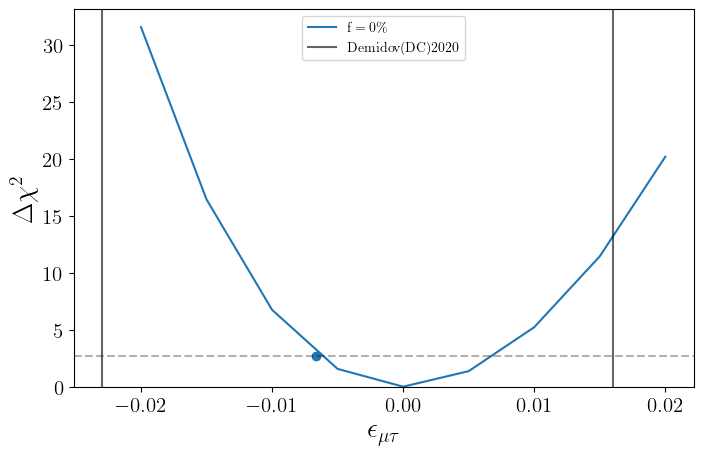

In [15]:
demidov_emt = (-0.023, 0.016)
fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(emt_range, deltachi_emt,label=r'$\mathrm{f = 0\%}$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(demidov_emt[0], alpha=0.6,c='black', label=r'$\mathrm{Demidov (DC) 2020}$')
plt.axvline(demidov_emt[1], alpha=0.6,c='black')
#plt.scatter((y2-y1)/(x2+x1) * chi2.ppf(0.9,1) + y1, chi2.ppf(0.9,1))

#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\epsilon_{\mu\tau}$', fontsize=20)
plt.ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend()
#save(fig, 'PINGU_3D_emt')

In [26]:
print(deltachi_emt)
print(emt_range)
x1 = deltachi_emt[3]
x2 = deltachi_emt[2]
y1 = emt_range[3]
y2 = emt_range[2]

'''
print((y2-y1)/(x2-x1) *(chi2.ppf(0.9,1)) + y1)
x1 = deltachi_emt[5]
x2 = deltachi_emt[6]
y1 = emt_range[5]
y2 = emt_range[6]
'''

print((y2-y1)/(x2-x1) *chi2.ppf(0.9,1) + y1)
print(dm31_range[best_dm31_index],th23_range[best_th23_index]*180/np.pi)

[31.535 16.419  6.737  1.559  0.     1.362  5.218 11.435 20.17 ]
[-0.02  -0.015 -0.01  -0.005  0.     0.005  0.01   0.015  0.02 ]
-0.0076126236892207644
0.002517 49.20000000000001


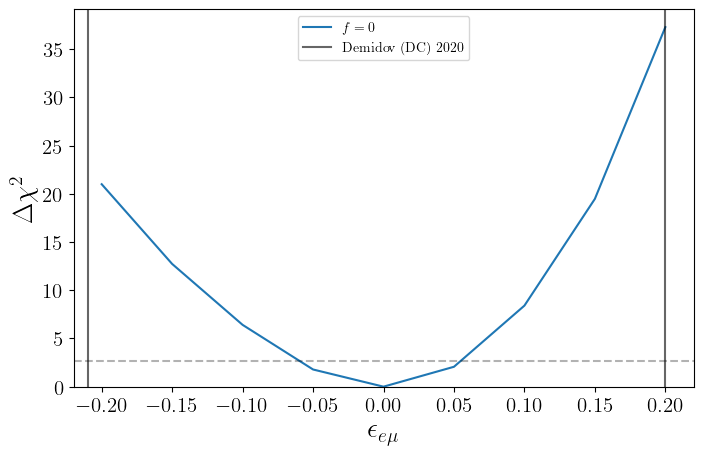

In [21]:
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(eem_range, deltachi_eem,label=rf'$f = {f}$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
ax.axvline(demidov_eem[0], alpha=0.6,c='black', label=r'Demidov (DC) 2020')
ax.axvline(demidov_eem[1], alpha=0.6,c='black')

#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
ax.set_ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
ax.set_xlabel(r'$\epsilon_{e\mu}$', fontsize=20)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.legend()
save(fig, 'PINGU_3D_eem')

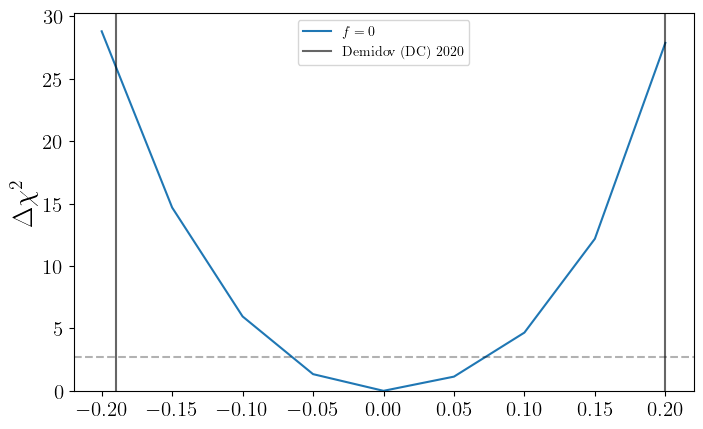

In [25]:
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(eet_range, deltachi_eet,label=rf'$f = {f}$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
ax.axvline(demidov_eet[0], alpha=0.6,c='black', label=r'Demidov (DC) 2020')
ax.axvline(demidov_eet[1], alpha=0.6,c='black')
ax.set_ylim(bottom=0)
#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5$\epsilon_{e\tau}$', fontsize=20)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.legend()
#save(fig, 'PINGU_3D_eet')

<ipython-input-12-ce7b58a5fd0d>:2: UserWarning: No contour levels were found within the data range.
  no_err = ax.contour(marginalized_deltachi[0,:,:,0].T,levels = [chi2.ppf(q=0.9, df = 2)])


"\nfmt_noerr = {}\nstrs = ['f=0 \\%']#,'f = 5 \\%']\nfor l, s in zip(no_err.levels, strs):\n    fmt_noerr[l] = s\n\nfmt_fiverr = {}\nstrs = ['f=5 \\%']\nfor l, s in zip(five_err.levels, strs):\n    fmt_fiverr[l] = s\n\nax.clabel(no_err, no_err.levels, inline=True, fmt=fmt_noerr, fontsize=10)\nax.clabel(five_err, five_err.levels, inline=True, fmt=fmt_fiverr, fontsize=10)\n"

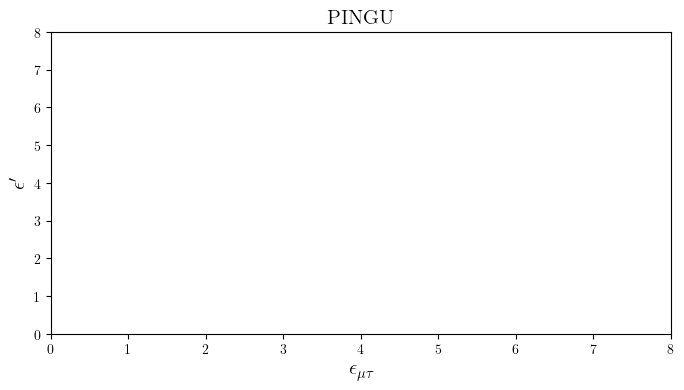

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
no_err = ax.contour(marginalized_deltachi[0,:,:,0].T,levels = [chi2.ppf(q=0.9, df = 2)])
#five_err = ax.contour(deltachi1.T,levels = [chi2.ppf(q=0.9, df = 2)], label='5 \% exp. uncert.', color='orange')
#ax.scatter(best_emt_index,best_emm_index, marker='*')
#_=ax.set_xticklabels(labels=np.round(emt_range,3))
#_=ax.set_yticklabels(labels=np.round(emm_range,3))
ax.set_xlabel(r'$\epsilon_{\mu\tau}$', fontsize=15)
ax.set_ylabel(r'$\epsilon^\prime$', fontsize=15)
plt.title(r'PINGU', fontsize=15)

'''
fmt_noerr = {}
strs = ['f=0 \%']#,'f = 5 \%']
for l, s in zip(no_err.levels, strs):
    fmt_noerr[l] = s

fmt_fiverr = {}
strs = ['f=5 \%']
for l, s in zip(five_err.levels, strs):
    fmt_fiverr[l] = s

ax.clabel(no_err, no_err.levels, inline=True, fmt=fmt_noerr, fontsize=10)
ax.clabel(five_err, five_err.levels, inline=True, fmt=fmt_fiverr, fontsize=10)
'''

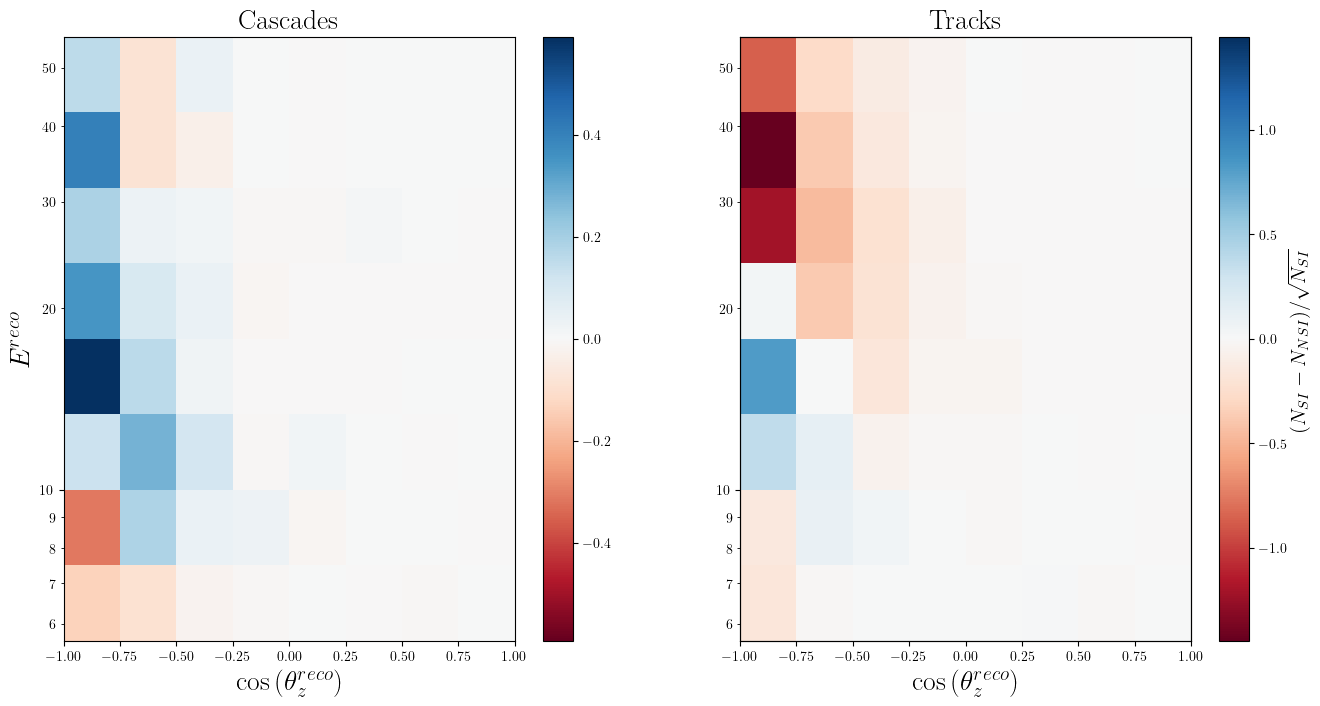

In [51]:
from matplotlib.colors import CenteredNorm
N_NSI_left = H1[emt_min_index]
N_NSI_right = H1[emt_max_index]
N_SI = H1[emt_SI_index] #H0
pull_min = (N_SI - N_NSI_left)/np.sqrt(N_SI)
pull_max = (N_SI - N_NSI_right)/np.sqrt(N_SI)
pull_diff = (N_NSI_left - N_NSI_right)/np.sqrt(N_SI)

titles = [r'$\mathrm{Cascades}$', r'$\mathrm{Tracks}$']
fig, ax = plt.subplots(1,2,figsize=(16,8))
for pid in [0,1]:
    ax[pid].set_title(titles[pid], fontsize=20)
    im = ax[pid].pcolormesh(zbins_2018,Ebins_2018, pull_min[pid], cmap='RdBu', norm= CenteredNorm(0))
    ax[pid].set_yscale('log')
    plt.colorbar(im, ax=ax[pid])
    ax[pid].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=20)
    
    ax[pid].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[pid].get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    #ax[pid].ticklabel_format(style='sci',axis='y')
    #ax[pid].tick_params(which='both',labelsize=13)
    ax[pid].set_yticks([10])
ax[0].set_ylabel(r'$E^{reco}$', fontsize=20)
ax2 = ax[1].twinx()
ax2.set_yticks([])
ax2.set_ylabel(r'$(N_{SI} - N_{NSI})/\sqrt{N_{SI}}$', fontsize=15, labelpad= 70)
#plt.suptitle(r'$[N(\epsilon_{\mu\tau}^-) - N(\epsilon_{\mu\tau}^+)]/\sqrt{N_{SI}}$ PINGU',fontsize=20)

fig.savefig('latex/article/figures/PINGU_event_pulls.pdf')
from subprocess import call 
_ = call('pdfcrop latex/article/figures/PINGU_event_pulls.pdf latex/article/figures/PINGU_event_pulls.pdf')